In [ ]:
!pip install emcee

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.stats
import emcee
import time
import numpy.random
# basic imports

from IPython import display
%matplotlib inline

# Model, likelihood, prior, and posterior

In [ ]:
def model(p, x):
    return (
        p[0] + p[1] * x + 5 * np.sin(x / p[2])
    )
# likelihood function

def like_outlier(p, xdat, ydat, errdat, doplot=False):
    # p are the function parameters
    # args carry anything we want to pass to our function (e.g. the data)

    pmodel = p[0:3]
    outlierfrac = p[3]    # fraction of dataset in outliers
    if outlierfrac < 0:
        return -1e10
    if outlierfrac >= 1:
        return -1e10

    ymod = model(p, xdat)

    prob = ((1 - outlierfrac) *
            scipy.stats.norm.pdf(ydat, ymod, errdat) +
            outlierfrac *
            scipy.stats.norm.pdf(ydat, 40, 100)
            )

    if doplot:
        makeplot(p, xdat, ydat, errdat)
    like = np.log(prob + 1e-200).sum()
    # log probabilities
    # we add tiny number to avoid NaNs

    # print p, like

    return like


# the logarithm of the prior
def logprior(p):
    zpt = p[0]    # normal mean= 0 , sig = 2
    logp = scipy.stats.norm.logpdf(zpt, 0, 2)

    slope = p[1]  # uniform from 0 to 5
    logp = logp + scipy.stats.uniform.logpdf(slope, 0., 5.)

    period = p[2]  # uniform from 1 to 4
    logp = logp + scipy.stats.uniform.logpdf(period, 1., 4.)

    fraction = p[3]     # uniform from 0 to 0.5
    logp = logp + scipy.stats.uniform.logpdf(fraction, 0, .5)

    return logp


def logposterior(p, xdat, ydat, errdat, doplot=False):
    #log(likelihood) + log(prior)
    return like_outlier(p, xdat, ydat, errdat, doplot=doplot) + \
        logprior(p)

# Data generating function

In [ ]:
def gendata(minx,maxx):
    ptrue = [1, 4, 2]
    # Our True model 1+ 2 * x + 3 * sin(x/4)

    npoints = 61  # was 61
    xs = np.random.uniform(minx, maxx, npoints)
    ys = model(ptrue, xs)
    # error-free data

    errs = np.random.uniform(0.2, 2, npoints)

    ys = ys + np.random.normal(size=npoints) * errs
    # perturb the data by the errors

    outliers = np.random.uniform(-20, 20, npoints)
    outlier_fraction = 0.1
    subset = np.random.uniform(size=npoints) < outlier_fraction
    ys[subset] = ys[subset] + outliers[subset]
    return ptrue, xs, ys ,errs


# Running the MCMC

In [ ]:
def run(doplot=False):
    # generate the data
    minx, maxx = 0, 20
    ptrue,xs,ys,errs = gendata(minx,maxx)
    plt.errorbar(xs, ys, errs, fmt='.')
    plt.plot(np.linspace(minx, maxx), model(ptrue, np.linspace(minx, maxx)))
    plt.draw()
    if doplot:
        plt.clf()
    p0 = np.array([0.5, 3, 2.5, 0.2])

    sigs = np.array([0.1, 0.1, .1, 0.02])

    ndim = 4  # number of dimensions of the problem

    randstate = np.random.mtrand.RandomState(0).get_state()

    if True:
        # run MCMC

        nwalkers = 8  # number of points in the Ensemble
        niterations = 5000
        burnin = 500

        p0s = emcee.utils.sample_ball(p0, sigs, nwalkers)
        # initialize the ball of initial conditions

        sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior,
                                        args=(xs, ys, errs), kwargs={
                                            'doplot': doplot}
                                        )
        # Supports the threads=X argument
        # for parallelization
        pos, lnprob, randstate = sampler.run_mcmc(
            p0s, burnin, rstate0=randstate)
        sampler.reset()
        # reset the sampler to forget the initial burnin samples

        pos, lnprob, randstate = sampler.run_mcmc(
            pos, niterations, rstate0=randstate)
        print ('Acceptance ratio', sampler.acceptance_fraction)


    return sampler


def plot_posteriors(chain):
    # plot the diagram with posterior distributions
    keys = [0, 1, 2, 3]
    plt.clf()  # clear plot
    counter = 0
    for k1 in keys:
        var1 = chain.flatchain[:, k1]
        # chain for variable k1
        for k2 in keys:
            var2 = chain.flatchain[:, k2]
            # chain for variable k1
            plt.subplot(4, 4, counter + 1)
            if k1 != k2:
                plt.hist2d(var2, var1, bins=[30, 30],cmap='viridis')
            else:
                plt.hist(var1, bins=30)
            counter += 1
    plt.draw()


def makeplot(p, xdat, ydat, errdat):

    plottype = 2
    display.clear_output(wait=True)

    if plottype == 1:
        if si.iter % 1 == 0:
            plt.clf()
            plt.errorbar(xdat, ydat, errdat, fmt='.')
            plt.plot(np.linspace(0, 20), model(p, np.linspace(0, 20)), color='red')
            plt.draw()
    elif plottype == 2:
        p1, p2 = 1, 2
        if si.iter == 0:
            plt.clf()
            plt.plot(p[p1], p[p2], 'o')
            plt.draw()
        else:
            if si.iter % 1 == 0:
                plt.plot([si.calls[-1][p1], p[p1]], [si.calls[-1][p2], p[p2]],
                      'o')
                plt.plot([si.calls[-1][p1], p[p1]], [si.calls[-1][p2], p[p2]],
                      )
            # oplot(np.linspace(0,20),model(p,np.linspace(0,20)),color='red')

                plt.draw()
                plt.pause(0.001)
    si.iter += 1
    si.calls.append(p)
    display.display(plt.gcf())


def animate_chain(ret):
    nit = 300
    for i in range(nit):
        plt.clf()
        plt.hist2d(ret.flatchain[:, 0], ret.flatchain[:, 1], range=[[0, 2],
                [3.9, 4.1]])
        plt.plot(ret.chain[:, i, 0], ret.chain[:, i, 1], 'o',color='red')
        plt.draw()
        plt.pause(0.001)


def convergence(mc):
    print( 'Autocorrelation times', mc.acor)
    # the length of the chain must be much larger than the auto-correlation
    # length
    # print( 'Chain 0, geweke test', pymc3.geweke(mc.chain[0, :, :], intervals=3))


class si:
    calls = []
    iter = 0
si.iter = 0
    # ret variable will have the output from the run()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)

Acceptance ratio [0.589  0.567  0.5702 0.5948 0.5746 0.5754 0.574  0.561 ]


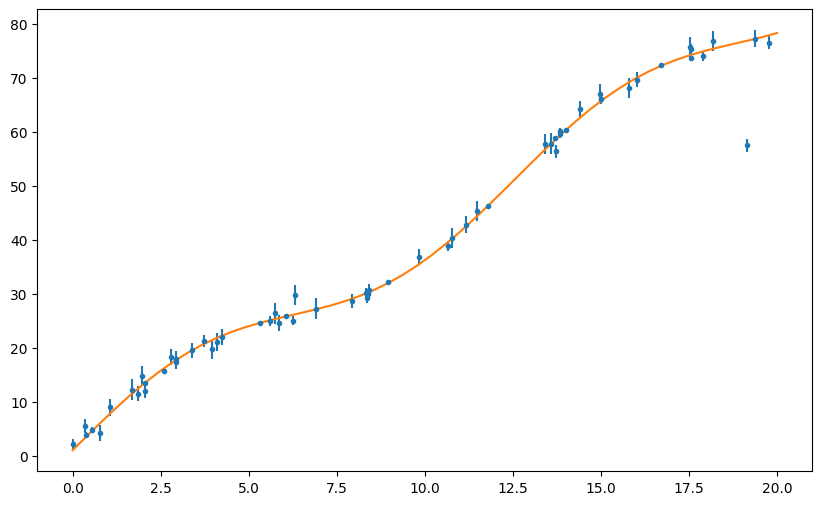

In [ ]:
np.random.seed(1)
ret = run()

# Illustration of the posterior distribution for all 4 parameters

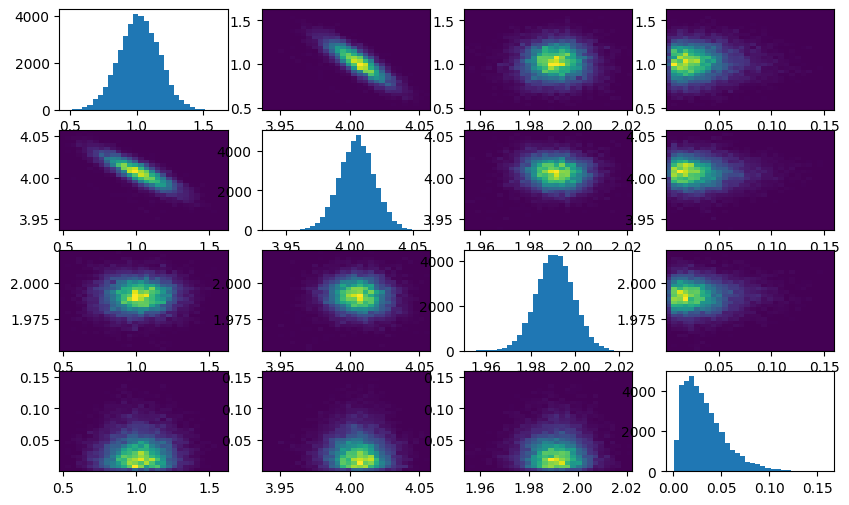

In [ ]:
plot_posteriors(ret)

In [ ]:
# The autocorrelation times need to be significantly smaller
# than the length of the chain
print (convergence(ret))

Autocorrelation times [52.31569601 51.59890597 60.37022882 78.32558136]
None


In [ ]:
print(ret.flatchain.shape)

(40000, 4)
